## 최선 접근법 구현
    1. GloVe 모델 적재
    2. 데이터셋 적재
    3. 전처리
    4. 미리 계산된 ID 행렬 적재
    5. 훈련 및 테스트 데이터셋 분할
    6. 신경망 구축
    7. 신경망 훈련
    8. 훈련된 모델 적재
    9. 훈련된 모델 테스트

***Import data and binary glove model saved in from of.npy format***

In [1]:
import numpy as np
wordsList = np.load('./data/wordsList.npy')
print('Loaded the word list!')
wordsList = wordsList.tolist() # Originally loaded as numpy array
wordsList = [word.decode('UTF-8') for word in wordsList] # Encode words as UTF-8
wordVectors = np.load('./data/wordVectors.npy')
print('Loaded the word vectors!')

Loaded the word list!
Loaded the word vectors!


In [2]:
print(len(wordsList))
print(wordVectors.shape)

400000
(400000, 50)


In [3]:
baseballIndex = wordsList.index('baseball')
wordVectors[baseballIndex]

array([-1.9327  ,  1.0421  , -0.78515 ,  0.91033 ,  0.22711 , -0.62158 ,
       -1.6493  ,  0.07686 , -0.5868  ,  0.058831,  0.35628 ,  0.68916 ,
       -0.50598 ,  0.70473 ,  1.2664  , -0.40031 , -0.020687,  0.80863 ,
       -0.90566 , -0.074054, -0.87675 , -0.6291  , -0.12685 ,  0.11524 ,
       -0.55685 , -1.6826  , -0.26291 ,  0.22632 ,  0.713   , -1.0828  ,
        2.1231  ,  0.49869 ,  0.066711, -0.48226 , -0.17897 ,  0.47699 ,
        0.16384 ,  0.16537 , -0.11506 , -0.15962 , -0.94926 , -0.42833 ,
       -0.59457 ,  1.3566  , -0.27506 ,  0.19918 , -0.36008 ,  0.55667 ,
       -0.70315 ,  0.17157 ], dtype=float32)

In [4]:
import tensorflow as tf
maxSeqLength = 10 # Maximum length of sentence
numDimensions = 300 # Dimensions for each word vector
firstSentence = np.zeros((maxSeqLength), dtype='int32')
firstSentence[0] = wordsList.index('i')
firstSentence[1] = wordsList.index('thought')
firstSentence[2] = wordsList.index('the')
firstSentence[3] = wordsList.index('movie')
firstSentence[4] = wordsList.index('was')
firstSentence[5] = wordsList.index('incredible')
firstSentence[6] = wordsList.index('and')
firstSentence[7] = wordsList.index('inspiring')
# firstSenence[8] and firstSentence[9] are going to be 0
print(firstSentence.shape)
print(firstSentence)

(10,)
[    41    804 201534   1005     15   7446      5  13767      0      0]


***Load dataset***

In [5]:
from os import listdir
from os.path import isfile, join
positiveFiles = ['./data/positiveReviews/' + f for f in listdir('./data/positiveReviews/')
                if isfile('./data/positiveReviews/'+f)]
negativeFiles = ['./data/negativeReviews/' + f for f in listdir('./data/negativeReviews/')
                if isfile('./data/negativeReviews/'+f)]
numWords = []
for pf in positiveFiles:
    with open(pf, 'r', encoding='utf-8') as f:
        line=f.readline()
        counter = len(line.split())
        numWords.append(counter)
print('Positive files finished')

for nf in negativeFiles:
    with open(nf, 'r', encoding='utf-8') as f:
        line=f.readline()
        counter = len(line.split())
        numWords.append(counter)
print('Negative files finished')

numFiles = len(numWords)
print('The total number of files is', numFiles)
print('The total number of words in the files is', sum(numWords))
print('the average number of words in the files is', sum(numWords)/len(numWords))


Positive files finished
Negative files finished
The total number of files is 25000
The total number of words in the files is 5844680
the average number of words in the files is 233.7872


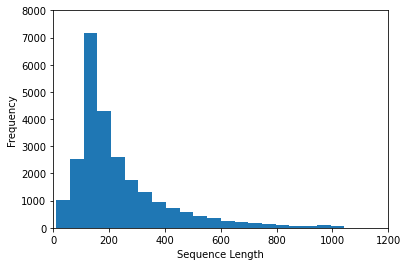

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(numWords, 50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axis([0, 1200, 0, 8000])
plt.show()

***pre-processing***

In [7]:
# Removes punctuation, parentheses, question marks, etc.., and leaves only alphanumeric characters
import re
strip_special_chars = re.compile('[^A-Za-z0-9 ]+')

def cleanSentences(string):
    string = string.lower().replace('<br />', ' ')
    return re.sub(strip_special_chars, '', stirng.lower())

***Load in a pre-computed IDs matrix***

In [8]:
# ids = np.zeros((numFiles, maxSeqLength), dtype='int32')
# fileCounter = 0
# for pf in positiveFiles:
#    with open(pf, "r") as f:
#        indexCounter = 0
#        line=f.readline()
#        cleanedLine = cleanSentences(line)
#        split = cleanedLine.split()
#        for word in split:
#            try:
#                ids[fileCounter][indexCounter] = wordsList.index(word)
#            except ValueError:
#                ids[fileCounter][indexCounter] = 399999 #Vector for unkown words
#            indexCounter = indexCounter + 1
#            if indexCounter >= maxSeqLength:
#                break
#        fileCounter = fileCounter + 1 

# for nf in negativeFiles:
#    with open(nf, "r") as f:
#        indexCounter = 0
#        line=f.readline()
#        cleanedLine = cleanSentences(line)
#        split = cleanedLine.split()
#        for word in split:
#            try:
#                ids[fileCounter][indexCounter] = wordsList.index(word)
#            except ValueError:
#                ids[fileCounter][indexCounter] = 399999 #Vector for unkown words
#            indexCounter = indexCounter + 1
#            if indexCounter >= maxSeqLength:
#                break
#        fileCounter = fileCounter + 1 
# #Pass into embedding function and see if it evaluates. 
# np.save('idsMatrix', ids)

In [9]:
ids = np.load('./data/idsMatrix.npy')

***Prepare Train and Test dataset***

In [18]:
def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0, 300)
    X_batch = tf.strings.regex_replace(X_batch, b'<br\\s*/?>', b' ')
    X_batch = tf.strings.regex_replace(X_batch, b'[^a-zA-Z]', b' ')
    X_batch = tf.strings.split(X_batch)
    return X_batch.to_tensor, y_batch

In [ ]:
from collections import Counter
vocabulary = Counter()
for X_batch, y_batch in 

***Define the hyper parameters***

In [11]:
batchSize = 24
lstmUnits = 64
numClasses = 2
iternations = 100000

***Strat building neural netword***

In [15]:
from tensorflow import keras

root_logdir = './logs'

def get_run_logdir():
    import time
    run_id = time.strftime('run_%Y_%m_%d-%H_%M_%S')
    return root_logdir + '/' + run_id

run_logdir = get_run_logdir()

tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [17]:
model = keras.models.Sequential([
    keras.layers.LSTM(lstmUnits, return_sequences=True, input_shape=[None, 1]),
    keras.layers.Dropout(0.75),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])